# BoostDM-CH vs Expert curated rules

In [4]:
import click
import gzip
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from io import StringIO
import seaborn as sns
import scipy.stats as stats
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 40)
%precision 2

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [6]:
### Annotate with boostDM-CH prediction
Rules_matrix = pd.read_csv('../../Paper_data/Expert_curated_rules/genes12_BoostdmCH_Harvard_run20230803.tsv.gz', sep='\t')
# Include an id per mutation
Rules_matrix['ID2'] = Rules_matrix['chr'].astype(str)+'-'+Rules_matrix['pos'].astype(str)+'-'+ Rules_matrix['alt'].astype(str)
Rules_matrix

,gene,ENSEMBL_TRANSCRIPT,ENSEMBL_GENE,chr,pos,alt,aachange,CLUSTL_SCORE,CLUSTL_cat_1,HotMaps_cat_1,smRegions_cat_1,PhyloP,nmd,Acetylation,Methylation,Phosphorylation,Regulatory_Site,Ubiquitination,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,selected_model_ttype,boostDM_score,boostDM_class,shap_CLUSTL_SCORE,shap_CLUSTL_cat_1,shap_HotMaps_cat_1,shap_smRegions_cat_1,shap_PhyloP,shap_nmd,shap_Acetylation,shap_Methylation,shap_Phosphorylation,shap_Regulatory_Site,shap_Ubiquitination,shap_csqn_type_missense,shap_csqn_type_nonsense,shap_csqn_type_splicing,shap_csqn_type_synonymous,row,Prot_pos,Niroula,Bick,CNIC,WHO,ID2
0,ASXL1,ENST00000375687,ENSG00000171456,20,32358779,C,K2Q,0.0,0,0,0,1.047852,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000014,0,-0.111320,0.0,0.0,0.000000,-0.442670,-0.308238,0.0,0.0,0.0,0.0,0.0,-1.168175,-2.783079,-0.099647,0.030009,0,2,0.0,0.0,0.0,0.0,20-32358779-C
1,ASXL1,ENST00000375687,ENSG00000171456,20,32358779,G,K2E,0.0,0,0,0,1.047852,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000014,0,-0.111320,0.0,0.0,0.000000,-0.442670,-0.308238,0.0,0.0,0.0,0.0,0.0,-1.168175,-2.783079,-0.099647,0.030009,1,2,0.0,0.0,0.0,0.0,20-32358779-G
2,ASXL1,ENST00000375687,ENSG00000171456,20,32358779,T,K2*,0.0,0,0,0,1.047852,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,CH,0.989503,1,-0.151095,0.0,0.0,0.000000,-0.304486,-0.415152,0.0,0.0,0.0,0.0,0.0,0.371912,2.419656,-0.038151,0.070408,2,2,0.0,0.0,0.0,0.0,20-32358779-T
3,ASXL1,ENST00000375687,ENSG00000171456,20,32358780,C,K2T,0.0,0,0,0,1.708984,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000011,0,-0.118665,0.0,0.0,0.000000,-0.550868,-0.296171,0.0,0.0,0.0,0.0,0.0,-1.170185,-2.774794,-0.099765,0.029898,3,2,0.0,0.0,0.0,0.0,20-32358780-C
4,ASXL1,ENST00000375687,ENSG00000171456,20,32358780,G,K2R,0.0,0,0,0,1.708984,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000011,0,-0.118665,0.0,0.0,0.000000,-0.550868,-0.296171,0.0,0.0,0.0,0.0,0.0,-1.170185,-2.774794,-0.099765,0.029898,4,2,0.0,0.0,0.0,0.0,20-32358780-G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87934,U2AF1,ENST00000291552,ENSG00000160201,21,43107490,C,A2G,0.0,0,0,0,7.027344,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.002605,0,-0.256177,0.0,0.0,-1.502649,-0.791911,0.000000,0.0,0.0,0.0,0.0,0.0,0.000850,0.000000,0.000000,0.000005,2146,2,0.0,0.0,0.0,0.0,21-43107490-C
87935,U2AF1,ENST00000291552,ENSG00000160201,21,43107490,T,A2E,0.0,0,0,0,7.027344,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.002605,0,-0.256177,0.0,0.0,-1.502649,-0.791911,0.000000,0.0,0.0,0.0,0.0,0.0,0.000850,0.000000,0.000000,0.000005,2147,2,0.0,0.0,0.0,0.0,21-43107490-T
87936,U2AF1,ENST00000291552,ENSG00000160201,21,43107491,A,A2S,0.0,0,0,0,5.570312,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.002207,0,-0.236594,0.0,0.0,-1.493413,-0.893124,0.000000,0.0,0.0,0.0,0.0,0.0,0.000854,0.000000,0.000000,0.000005,2148,2,0.0,0.0,0.0,0.0,21-43107491-A
87937,U2AF1,ENST00000291552,ENSG00000160201,21,43107491,G,A2P,0.0,0,0,0,5.570312,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.002207,0,-0.236594,0.0,0.0,-1.493413,-0.893124,0.000000,0.0,0.0,0.0,0.0,0.0,0.000854,0.000000,0.000000,0.000005,2149,2,0.0,0.0,0.0,0.0,21-43107491-G


#### Functions to include protein body

In [7]:
def get_PFAMs_per_transcript(PFAM_files, PFAM_info, transcript):
    df_pfam = pd.read_csv(PFAM_files, sep="\t", names=["ENSEMBL_GENE", "ENSEMBL_TRANSCRIPT", "START", "END", "DOMAIN"])
    df_names = pd.read_csv(PFAM_info, sep="\t", names=["DOMAIN", "CLAN", "CLAN_NAME", "DOMAIN_NAME", "Long Name"])

    # Get domains
    df_pfam_gene = df_pfam[(df_pfam["ENSEMBL_TRANSCRIPT"] == transcript)]
    df_pfam_gene = df_pfam_gene[["ENSEMBL_TRANSCRIPT", "START", "END", "DOMAIN"]].drop_duplicates()
    df_pfam_gene = pd.merge(df_pfam_gene, df_names[["DOMAIN", "DOMAIN_NAME"]].drop_duplicates(), how="left")
    df_pfam_gene["POS"] = df_pfam_gene.apply(lambda row: row["START"] + ((row["END"] - row["START"]) // 2), axis=1)
    df_pfam_gene["SIZE"] = df_pfam_gene.apply(lambda row: row["END"] - row["START"] + 1, axis=1)
    df_pfam_gene["Color"] = "#998ec3"

    return df_pfam_gene

def get_transctipt(gene):
    return Rules_matrix[Rules_matrix['gene']==gene]['ENSEMBL_TRANSCRIPT'].unique()[0]

# Comparisons for all 12 genes

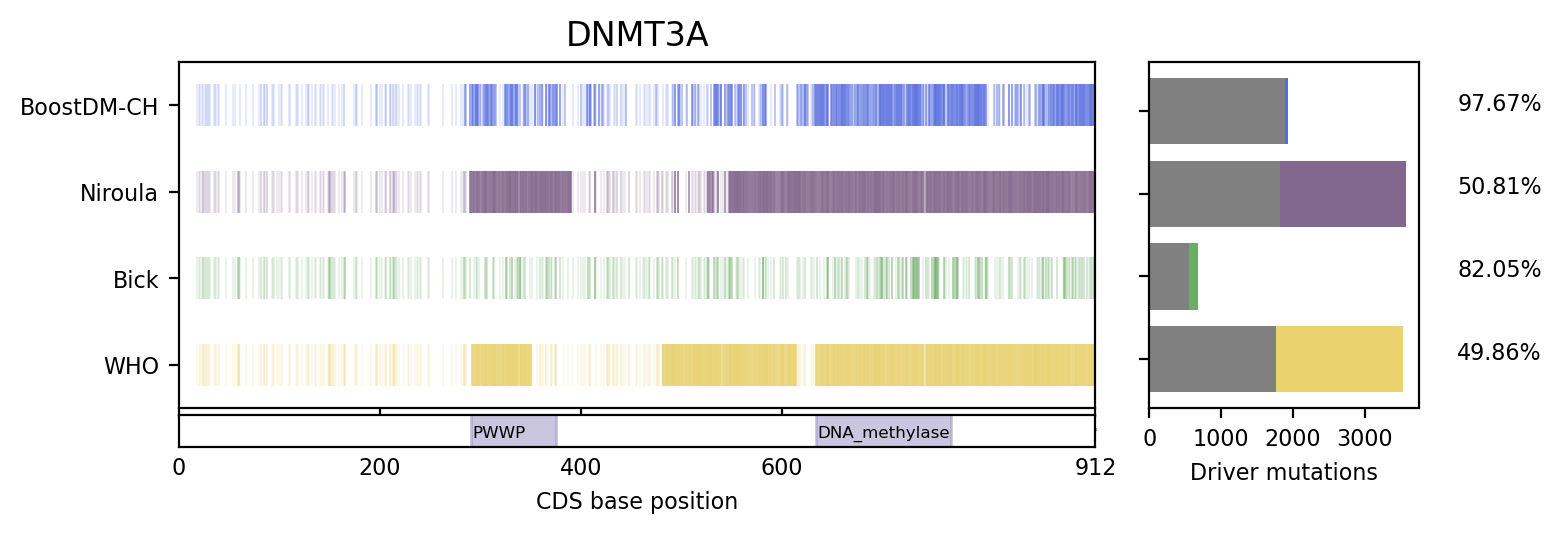

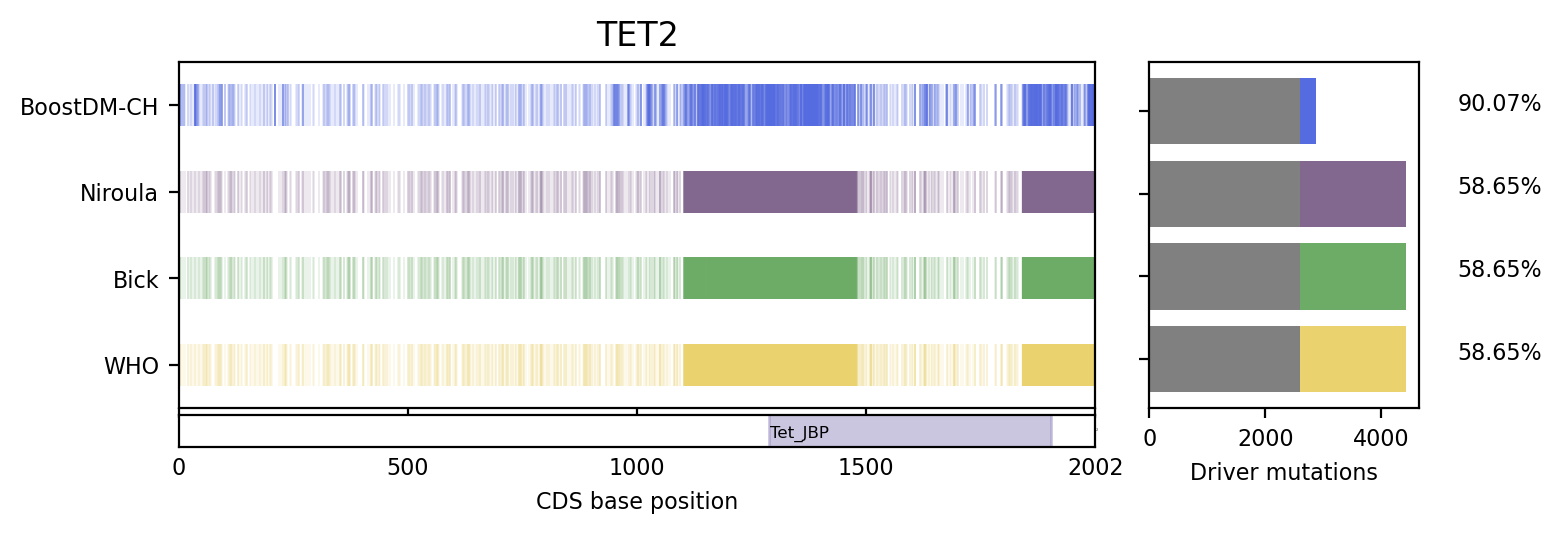

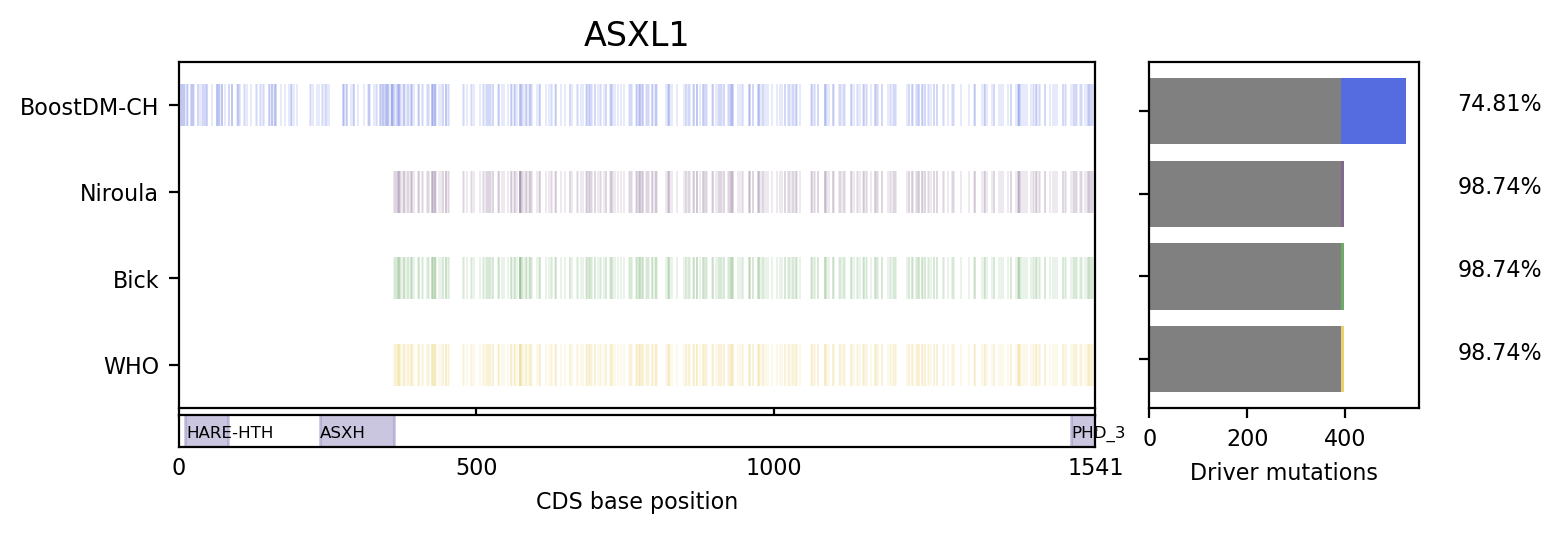

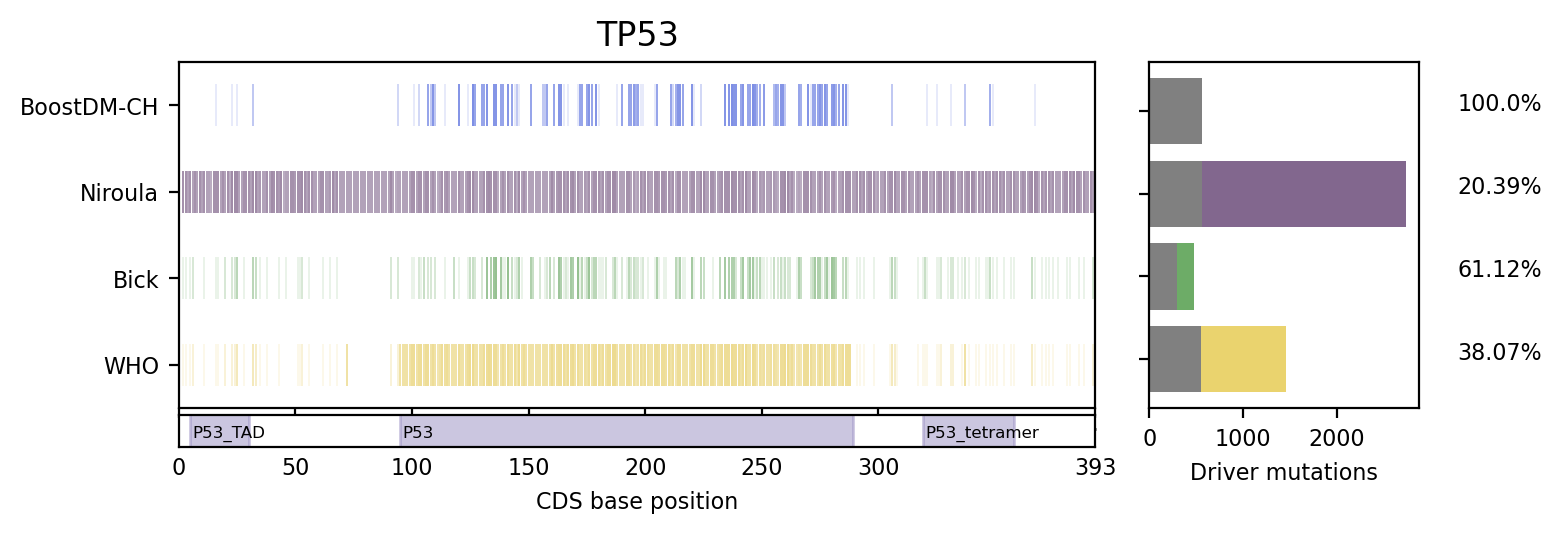

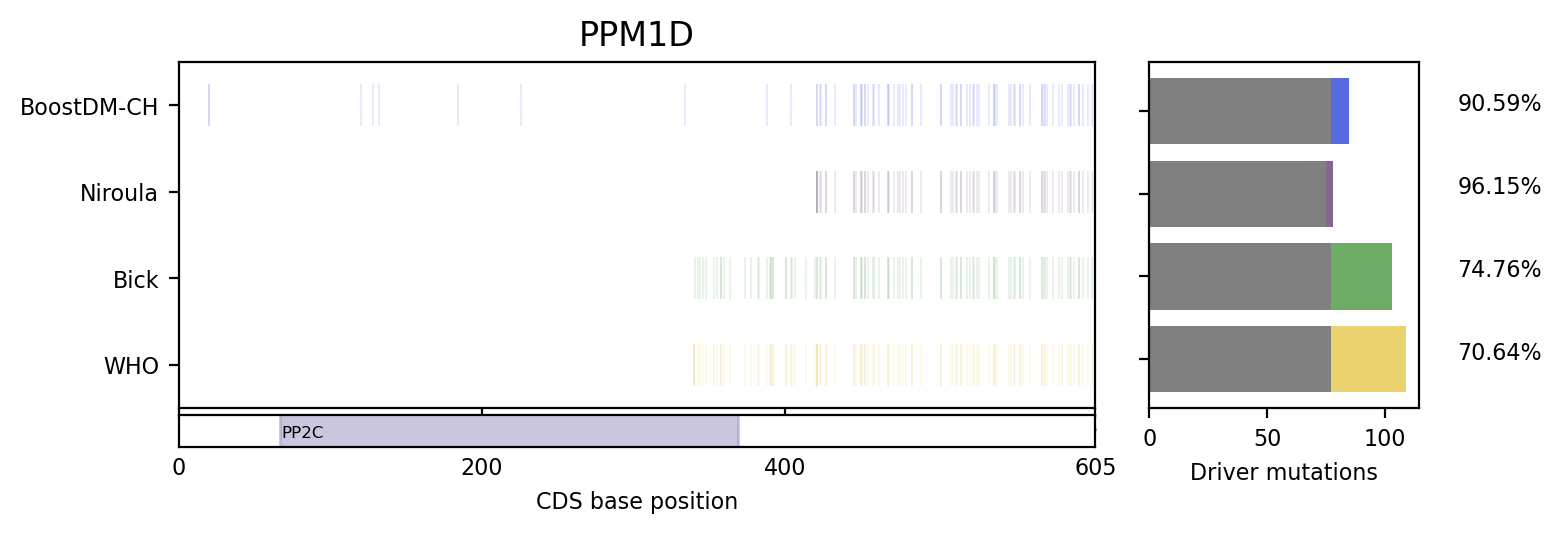

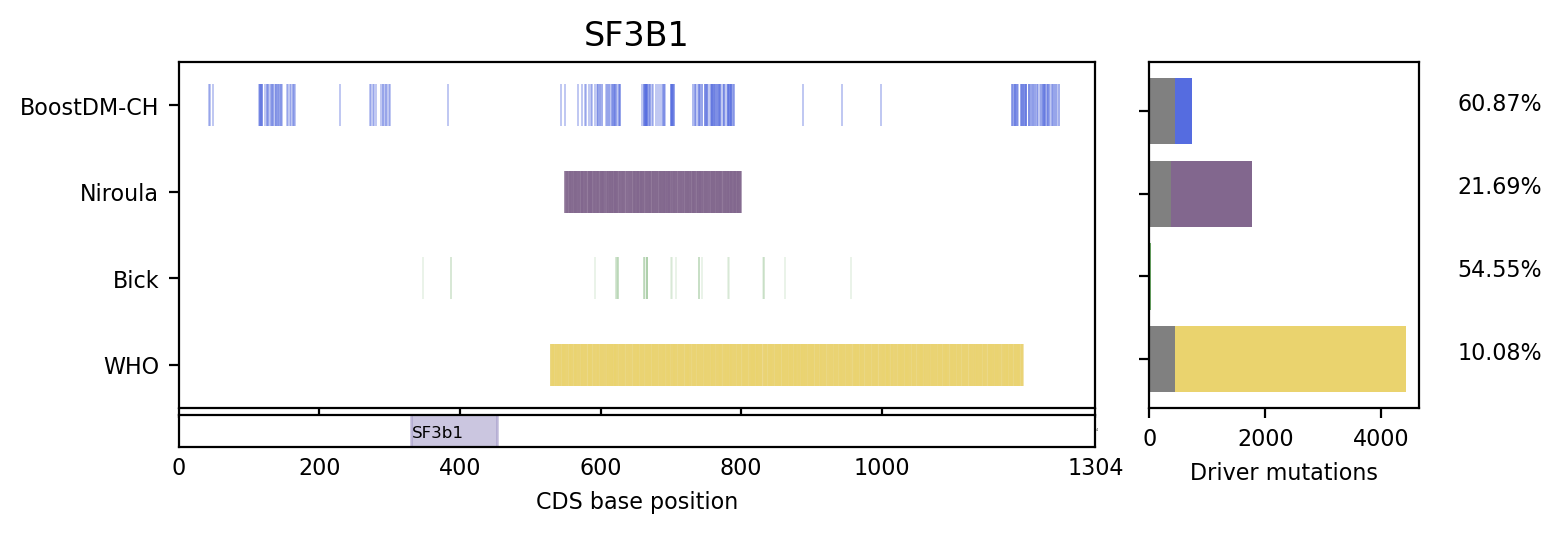

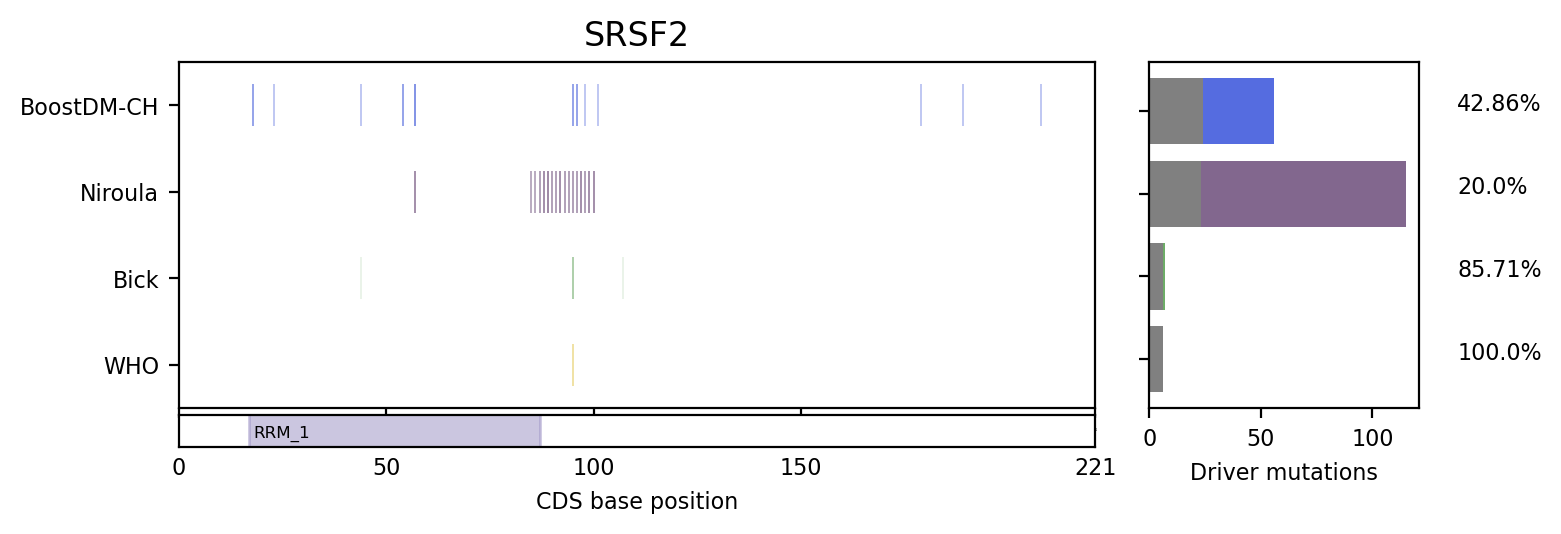

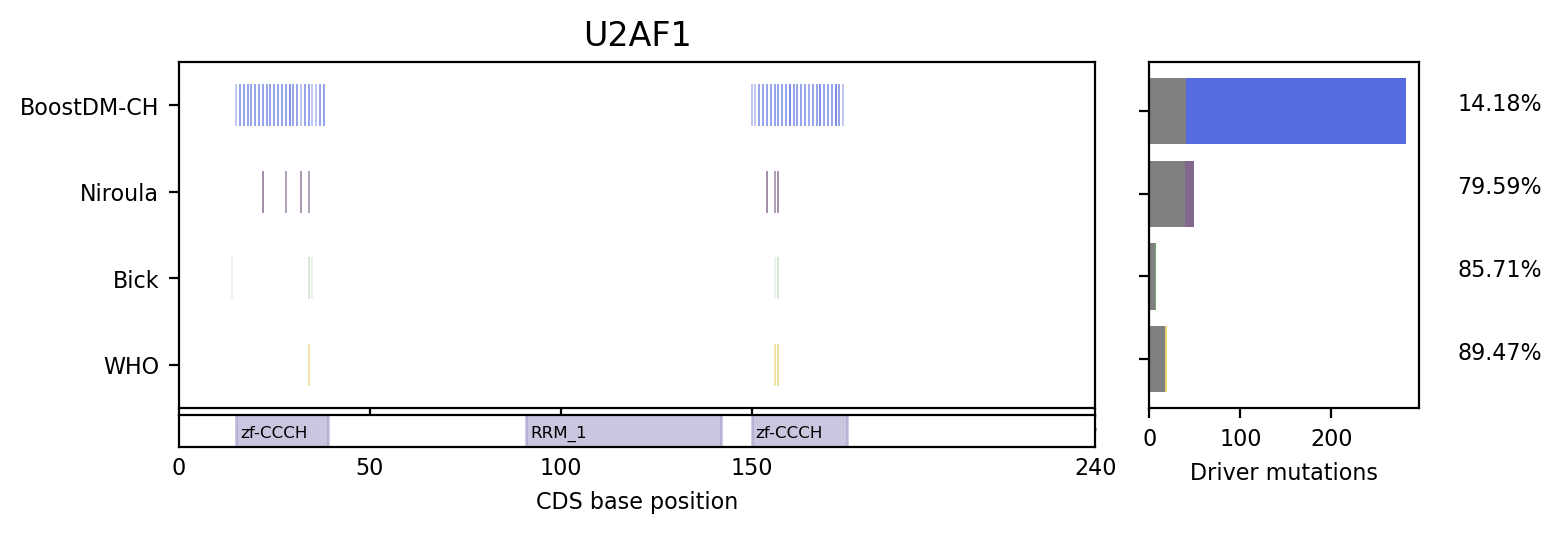

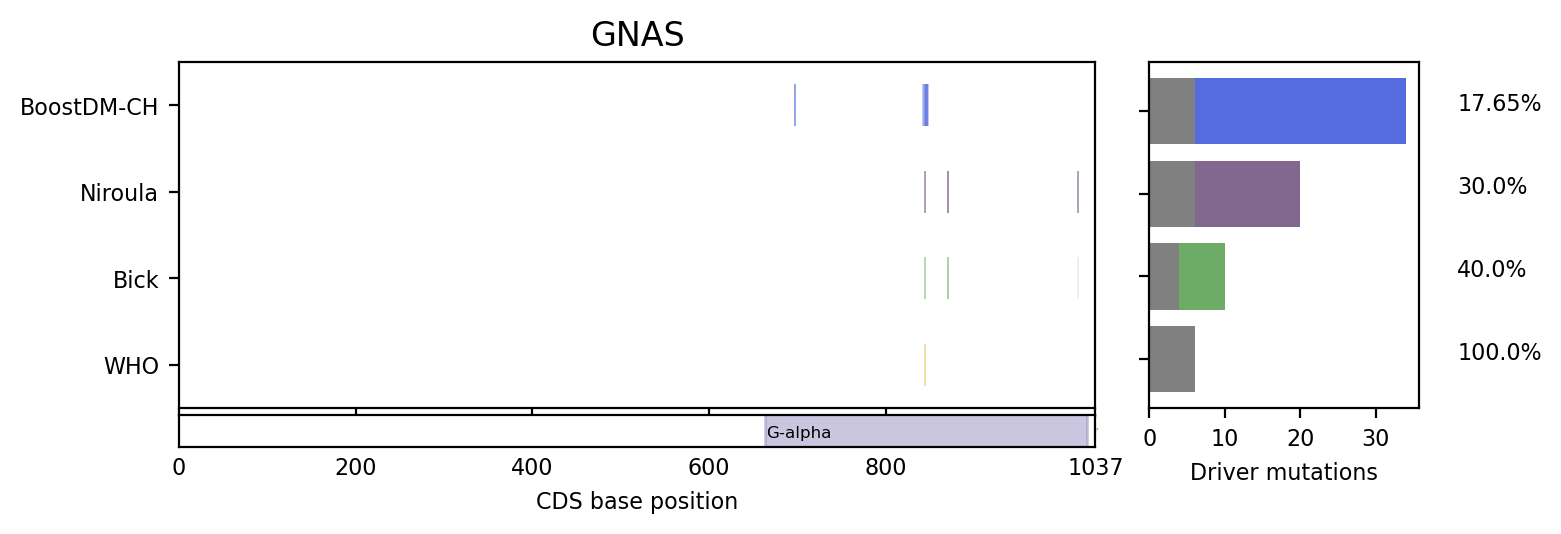

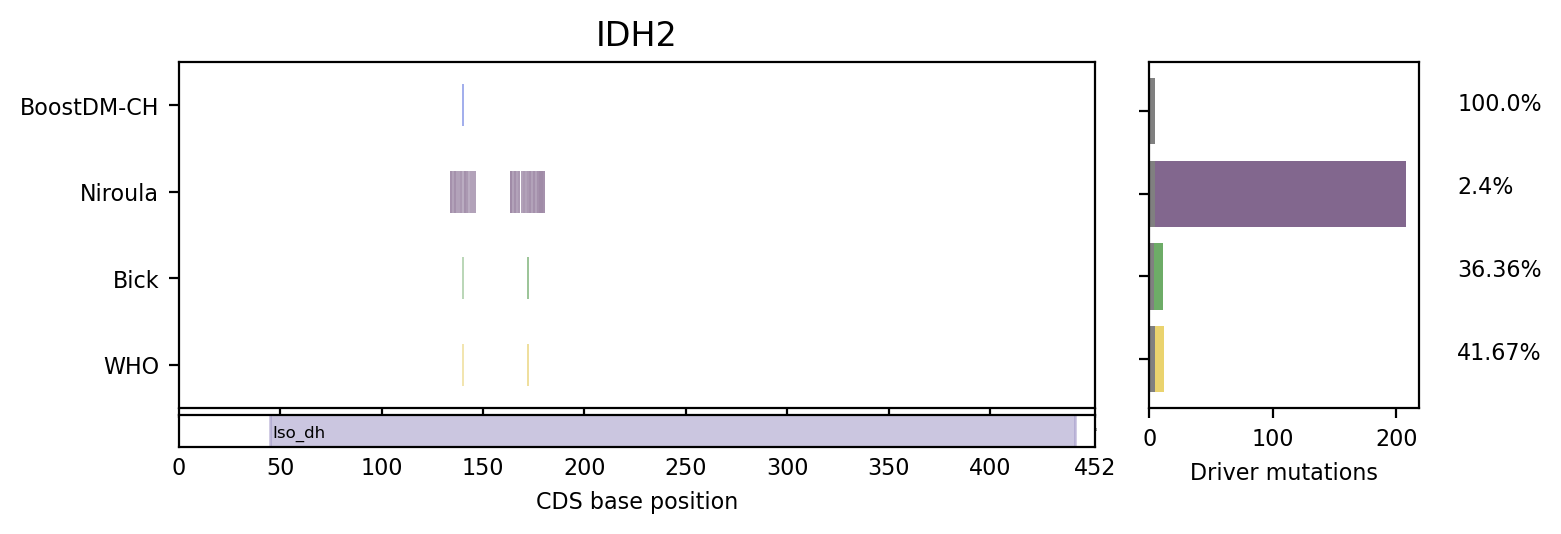

In [8]:
from matplotlib import gridspec
import matplotlib.patches as patches
import matplotlib
import matplotlib.pyplot as plt

for gene in ['DNMT3A', 'TET2', 'ASXL1', 'TP53','PPM1D', 'SF3B1', 'SRSF2', 'U2AF1', 'GNAS', 'IDH2']:

    fig = plt.figure(figsize=(8, 2.5), dpi=200)
    gs = gridspec.GridSpec(10, 4, figure=fig)
    # Method comparison
    ax0 = plt.subplot(gs[:-1, :3])
    #protein body
    ax1 = plt.subplot(gs[-1, :3], sharex=ax0)
    #Method overlapping
    ax2 = plt.subplot(gs[:-1, 3])

    GENE = Rules_matrix[(Rules_matrix['gene']==gene)]

    # get PFAM domains and subset the mutation data
    PFAM_files = '../../Paper_data/pfam/pfam_biomart.tsv.gz'
    PFAM_info = '../../Paper_data/pfam/pfam_names.info.csv'
    subset_data_pfam = get_PFAMs_per_transcript(PFAM_files, PFAM_info, get_transctipt(gene))
    subset_data_pfam

    ######
    #BARPLOT
    ######
    BoostDM = len(GENE[(GENE['boostDM_class']==1)]['ID2'].to_list())
    Niroula = len(GENE[(GENE['Niroula']==1)]['ID2'].to_list())
    Overlapping_Niroula = len(GENE[(GENE['boostDM_class']==1) & (GENE['Niroula']==1)]['ID2'].to_list())
    Bick = len(GENE[(GENE['Bick']==1)]['ID2'].to_list())
    Overlapping_Bick = len(GENE[(GENE['boostDM_class']==1) & (GENE['Bick']==1)]['ID2'].to_list())
    WHO = len(GENE[(GENE['WHO']==1)]['ID2'].to_list())
    Overlapping_WHO = len(GENE[(GENE['boostDM_class']==1) & (GENE['WHO']==1)]['ID2'].to_list())
    allposition = set(GENE[(GENE['Niroula']==1)]['ID2'].to_list()+GENE[(GENE['Bick']==1)]['ID2'].to_list()+GENE[(GENE['WHO']==1)]['ID2'].to_list())
    Overlaping_all=len(GENE[(GENE['boostDM_class']==1) & (GENE['ID2'].isin(list(set(allposition))))])

    # create data
    x = ['WHO', 'Bick', 'Niroula', 'BoostDM-CH']
    y1 = [Overlapping_WHO, Overlapping_Bick, Overlapping_Niroula, Overlaping_all]
    y2 = [0, 0, 0, BoostDM-Overlaping_all]
    y3 = [0, 0, Niroula-Overlapping_Niroula, 0]
    y4 = [0, Bick-Overlapping_Bick, 0, 0]
    y5 = [WHO-Overlapping_WHO, 0, 0, 0]
    h = 0.6
    size_param = 8

    # plot bars in stack manner
    #     plt.figure(figsize=(4, 2))
    max_len = max([BoostDM,Niroula,Bick,WHO])
    ax2.barh(x, y1, color='grey')
    ax2.barh(x, y2, left=y1, color='#556CE0')
    ax2.barh(x, y3, left=y1, color='#82678E')
    ax2.barh(x, y4, left=y1, color='#6DAC67')
    ax2.barh(x, y5, left=y1, color='#EAD36E')
    ax2.text(max_len+(max_len/5), 0, str(round(Overlapping_WHO/WHO*100, 2))+'%', size=size_param)
    ax2.text(max_len+(max_len/5), 1, str(round(Overlapping_Bick/Bick*100, 2))+'%', size=size_param)
    ax2.text(max_len+(max_len/5), 2, str(round(Overlapping_Niroula/Niroula*100, 2))+'%', size=size_param)
    ax2.text(max_len+(max_len/5), 3, str(round(Overlaping_all/BoostDM*100, 2))+'%', size=size_param)
    ax2.set_yticklabels([])
    ax2.tick_params(axis='x', labelsize=8)
    ax2.set_xlabel('Driver mutations', fontsize = size_param)

    ######
    #Protein domains
    ######
    ax1.set_xlabel('CDS base position',fontsize = size_param)
    ax1.tick_params(axis='x', length=0)
    ax1.set_yticks([])

    ax1.set_ylim(0, 1)
    for i, r in subset_data_pfam.iterrows():
        start_base = r['START']
        size_base = r['SIZE']
        rect = patches.Rectangle(xy=(start_base, 0), width=size_base, height=5, color=r["Color"], alpha=0.5, zorder=2)
        ax1.annotate(text=r["DOMAIN_NAME"], xy=(start_base + 1, 0.3), fontsize=6)
        ax1.add_patch(rect)
    ax1.set_xlim(0, max(GENE['Prot_pos']))
    ax1.set_xticks(np.append(np.arange(0, max(GENE['Prot_pos']), 200)[:-1], max(GENE['Prot_pos'])))
    ax1.set_xticklabels(np.append(np.arange(0, max(GENE['Prot_pos']), 200)[:-1], max(GENE['Prot_pos'])), fontsize = 8)

    ######
    #Method comparison             
    ######
    ax0.set_title(gene)
    ax0.plot(GENE[GENE['boostDM_class']==1]['Prot_pos'], np.full_like(GENE[GENE['boostDM_class']==1]['Prot_pos'], 6), '|', markeredgewidth=0.1, markersize=15, color='#556CE0')
    ax0.plot(GENE[GENE['Niroula']==1]['Prot_pos'], np.full_like(GENE[GENE['Niroula']==1]['Prot_pos'], 4), '|k', markeredgewidth=0.1,  markersize=15, color='#82678E')
    ax0.plot(GENE[GENE['Bick']==1]['Prot_pos'], np.full_like(GENE[GENE['Bick']==1]['Prot_pos'], 2), '|k', markeredgewidth=0.1,  markersize=15, color='#6DAC67')
    ax0.plot(GENE[GENE['WHO']==1]['Prot_pos'], np.full_like(GENE[GENE['WHO']==1]['Prot_pos'], 0), '|k', markeredgewidth=0.1,  markersize=15, color='#EAD36E')
    ax0.set_ylim(-1, 7)
    if max(GENE['Prot_pos'])<500:
        ax0.set_xticks(np.append(np.arange(0, max(GENE['Prot_pos']), 50)[:-1], max(GENE['Prot_pos'])))
        ax0.set_xticklabels(np.append(np.arange(0, max(GENE['Prot_pos']), 50)[:-1], max(GENE['Prot_pos'])), fontsize = 0)
    elif max(GENE['Prot_pos'])<1400:
        ax0.set_xticks(np.append(np.arange(0, max(GENE['Prot_pos']), 200)[:-1], max(GENE['Prot_pos'])))
        ax0.set_xticklabels(np.append(np.arange(0, max(GENE['Prot_pos']), 200)[:-1], max(GENE['Prot_pos'])), fontsize = 0)
    elif max(GENE['Prot_pos'])>=1000:
        ax0.set_xticks(np.append(np.arange(0, max(GENE['Prot_pos']), 500)[:-1], max(GENE['Prot_pos'])))
        ax0.set_xticklabels(np.append(np.arange(0, max(GENE['Prot_pos']), 500)[:-1], max(GENE['Prot_pos'])), fontsize = 0)
    ax0.set_yticks([0,2,4,6])
    ax0.set_yticklabels(['WHO', 'Bick', 'Niroula', 'BoostDM-CH'], fontsize = size_param)   
#     plt.savefig('Method_comparison_'+gene+'.png', dpi=400,  bbox_inches='tight')

# Comparisons with nonsense, missense

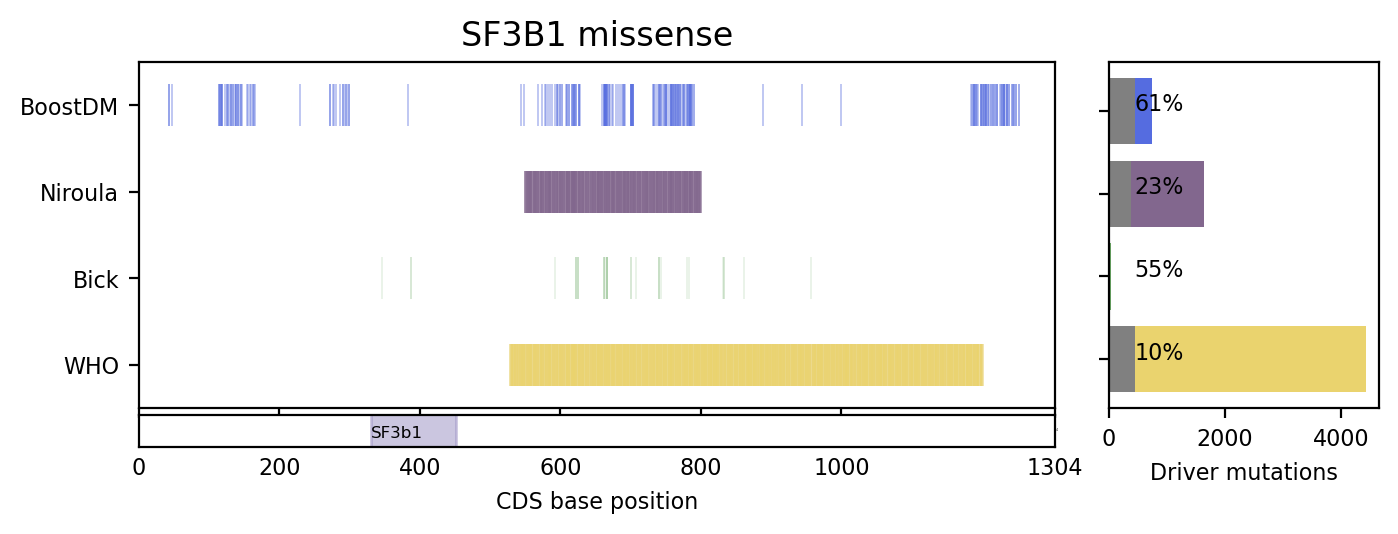

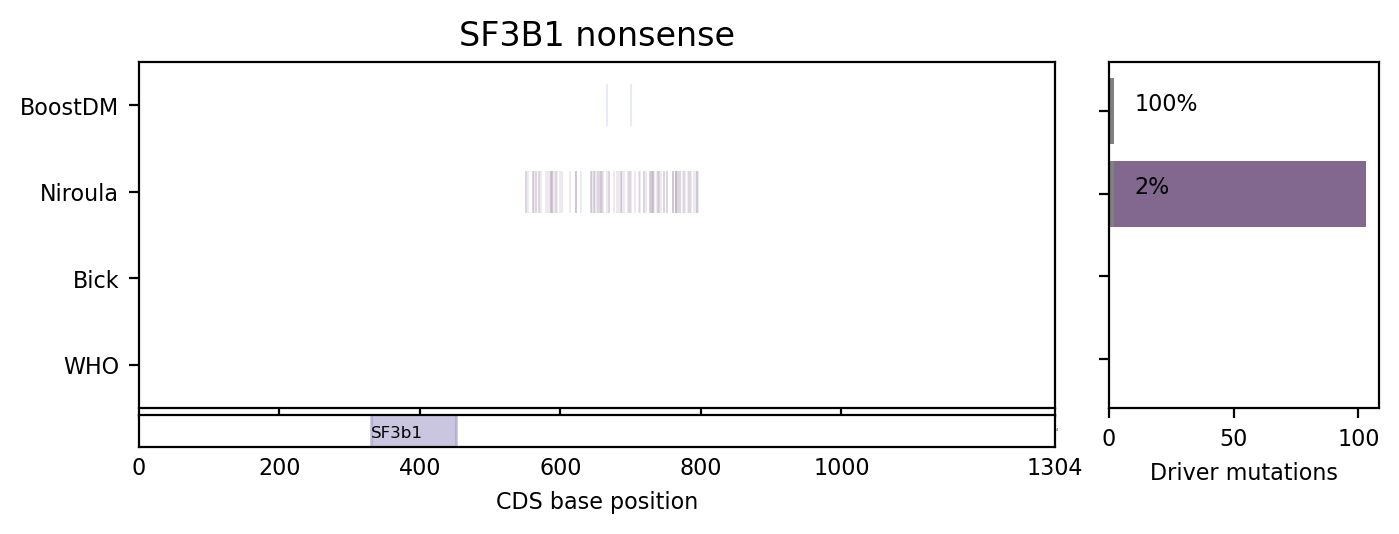

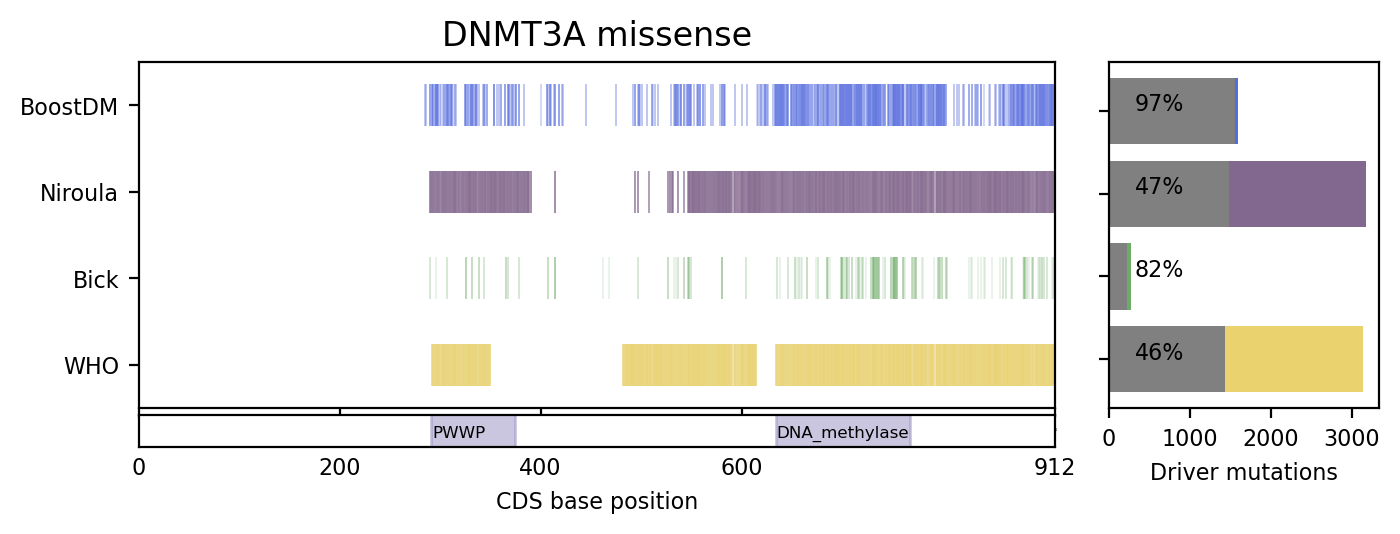

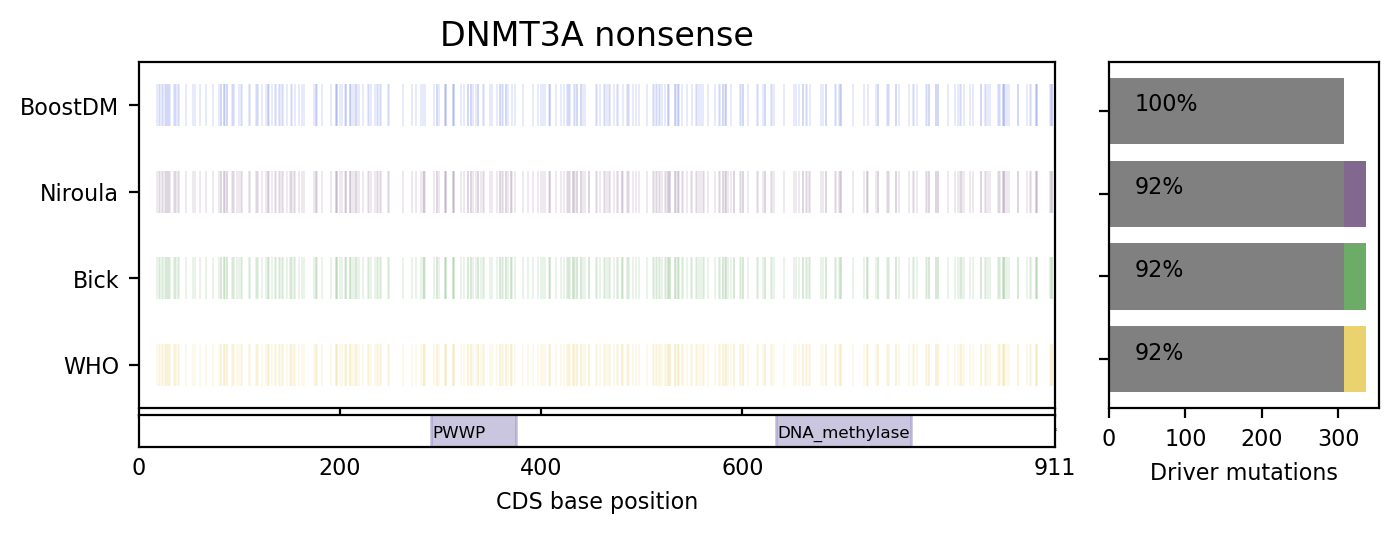

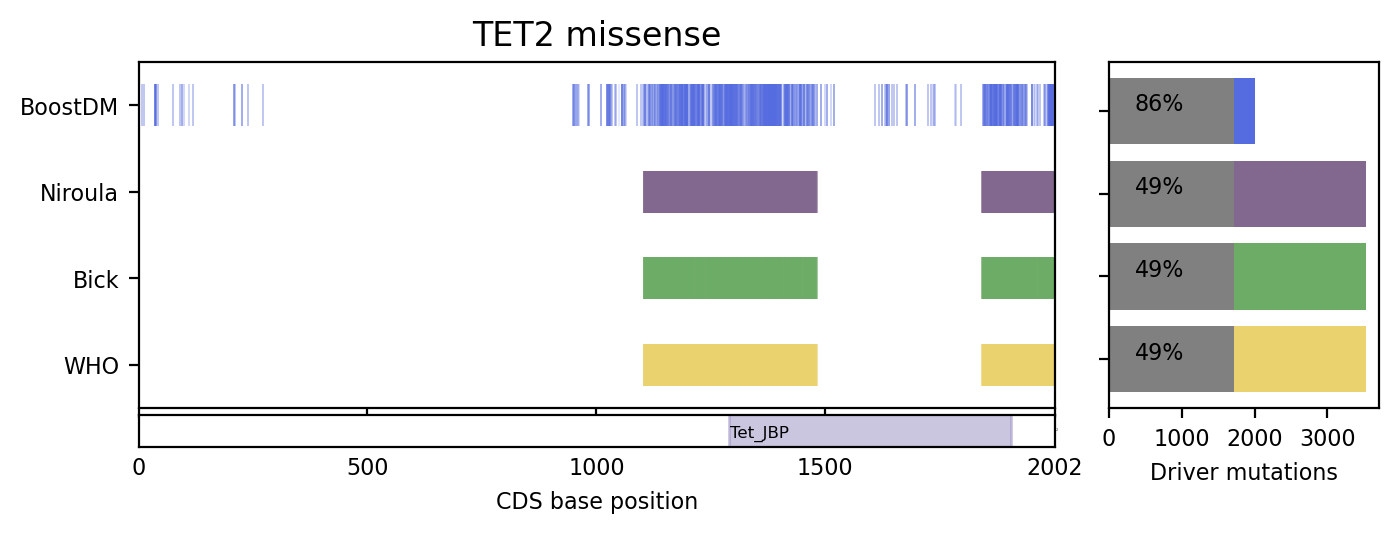

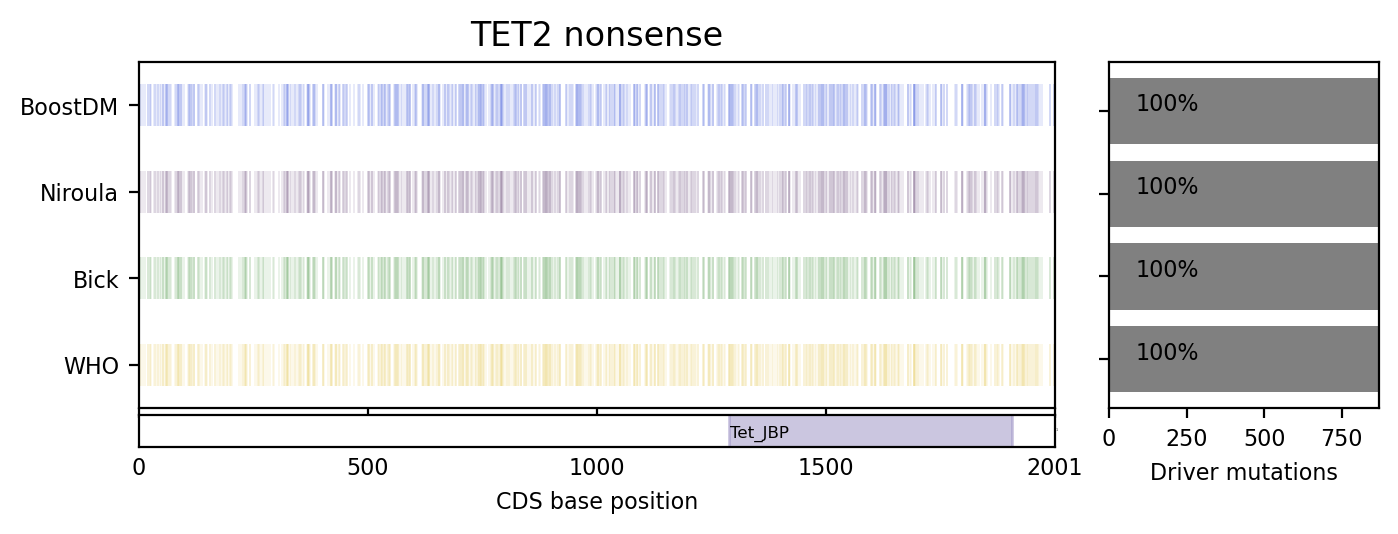

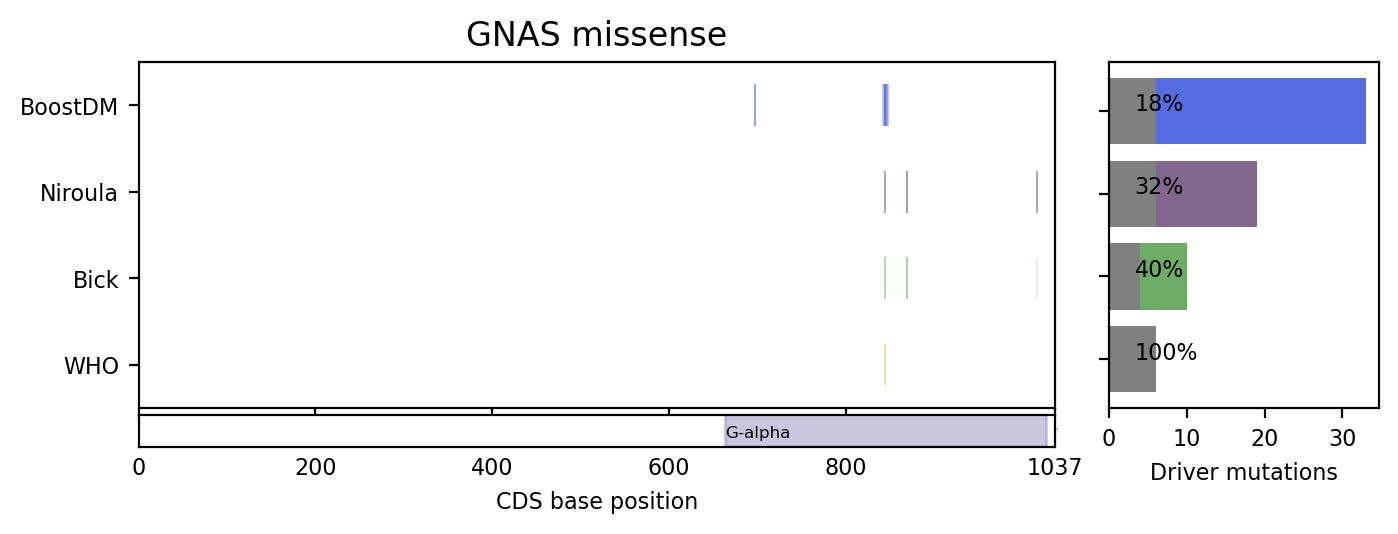

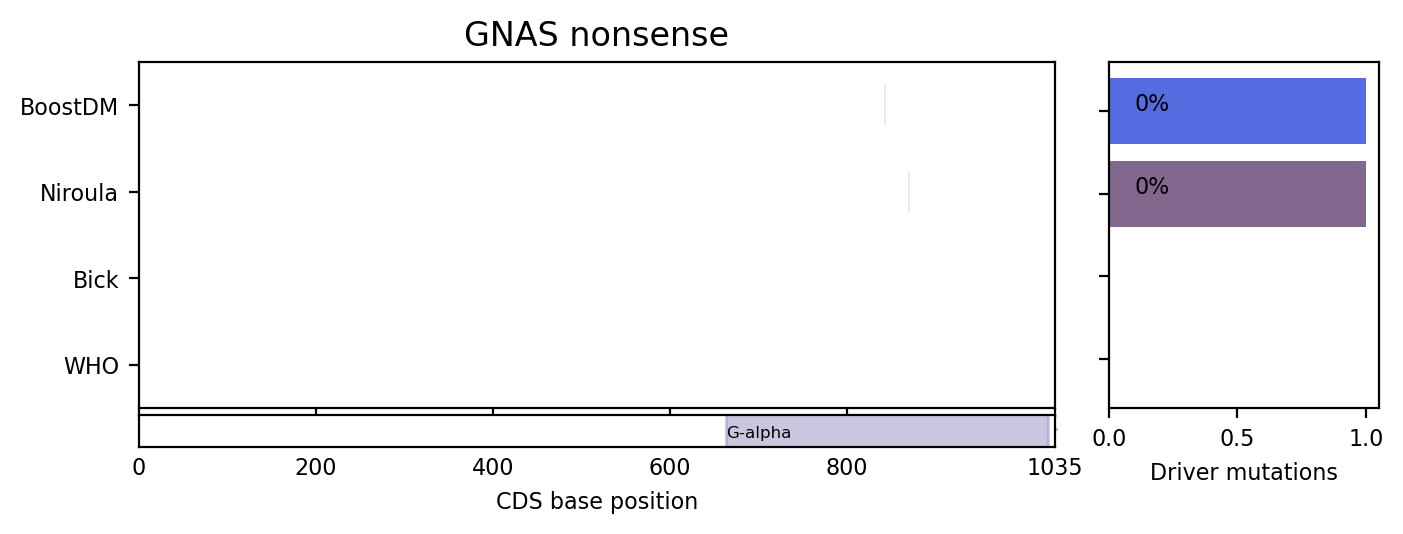

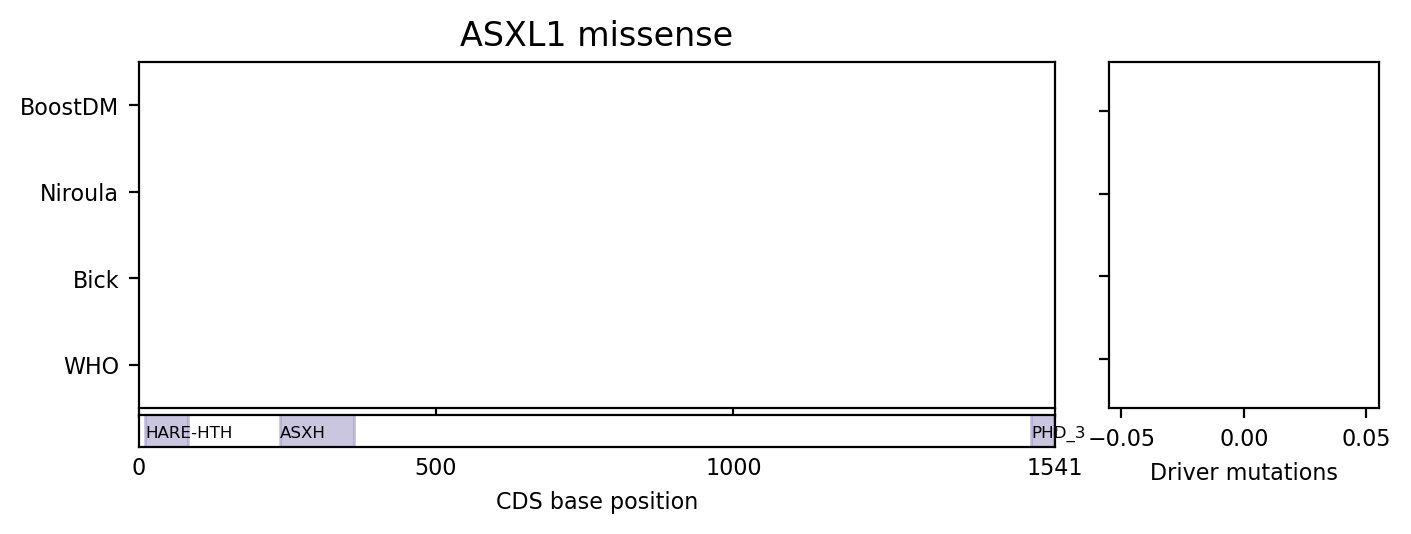

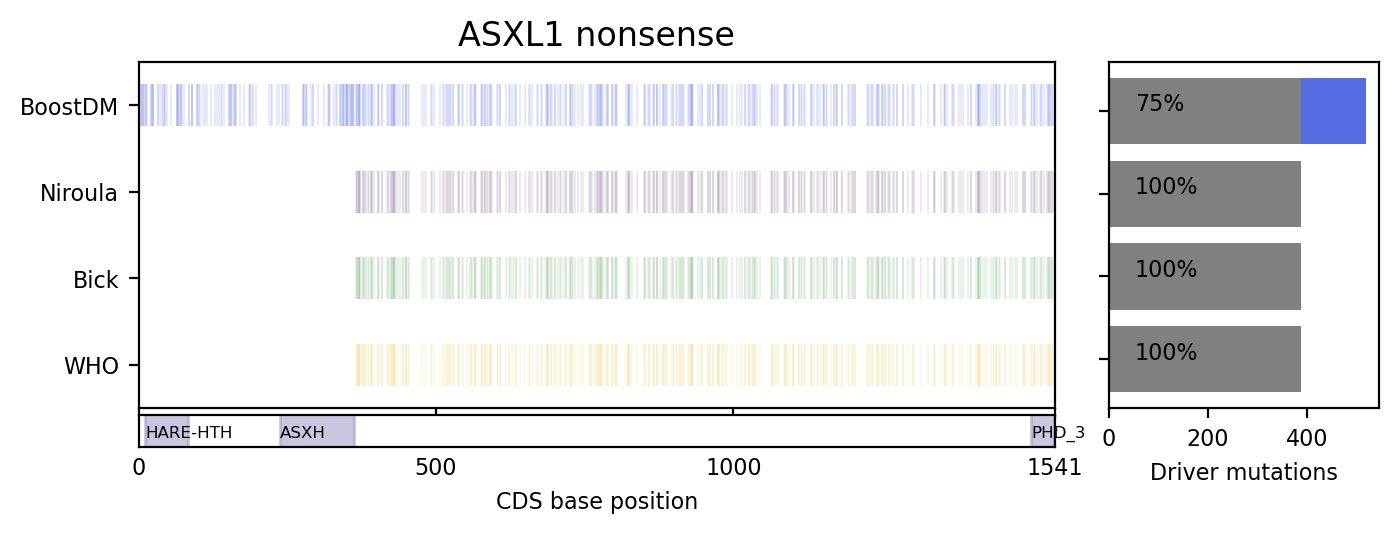

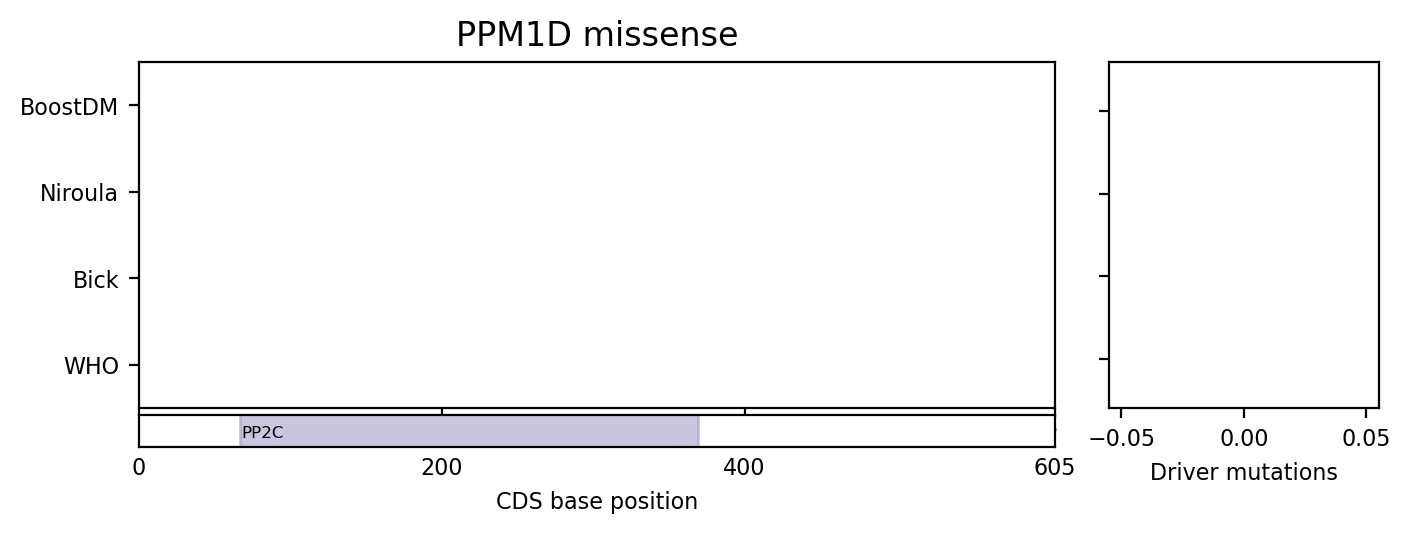

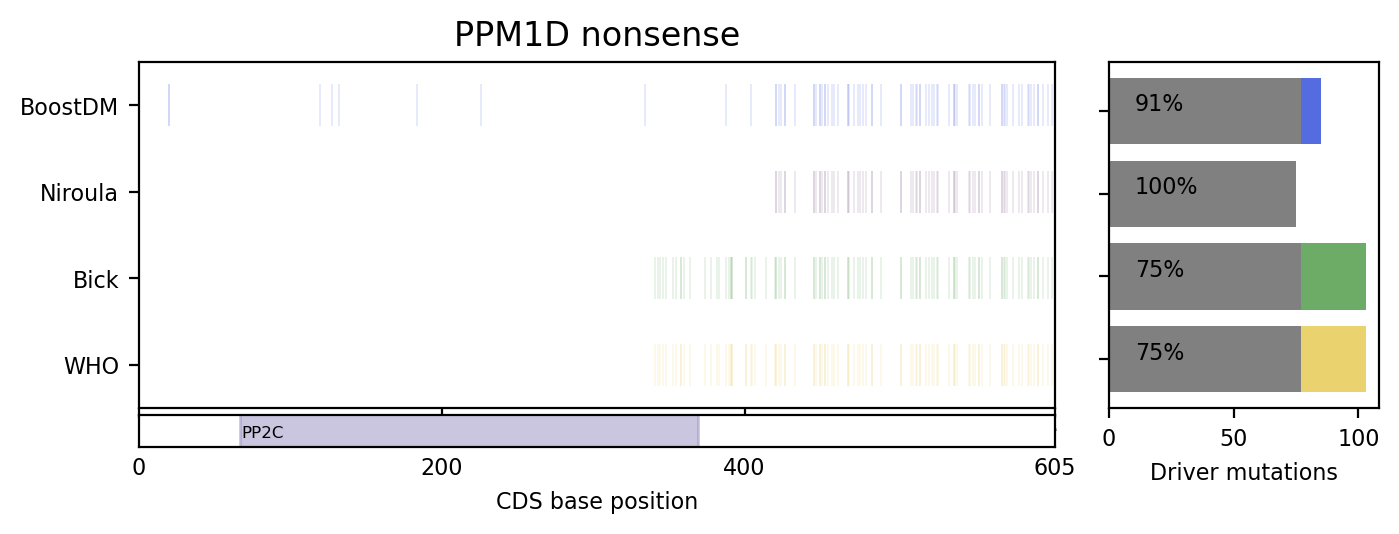

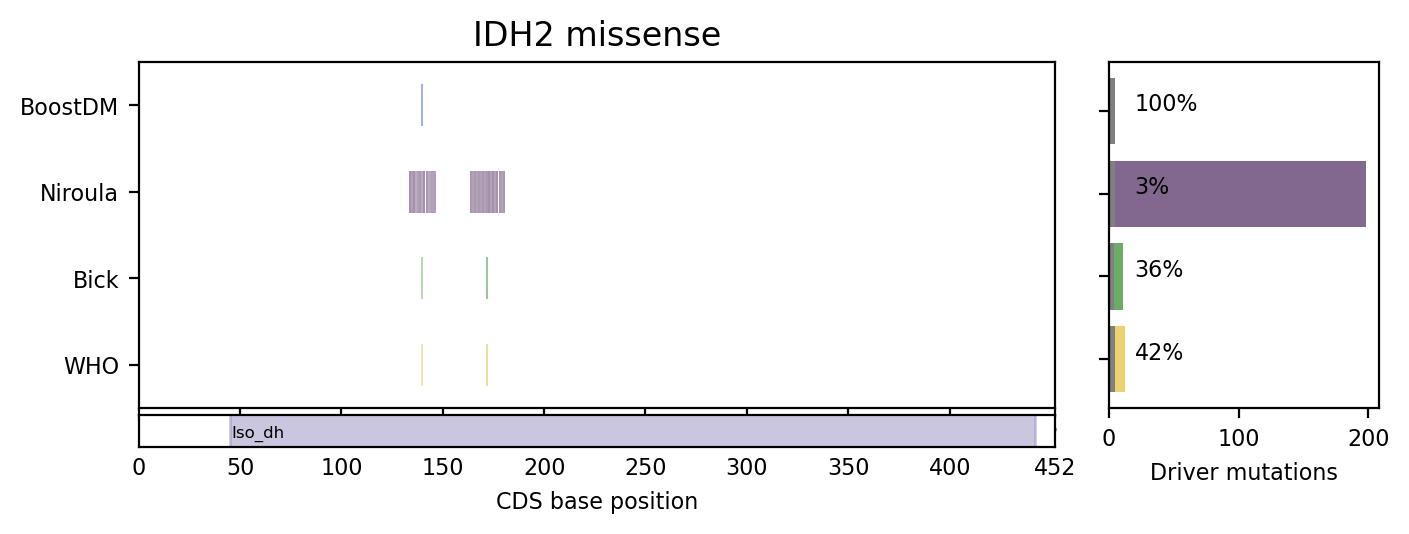

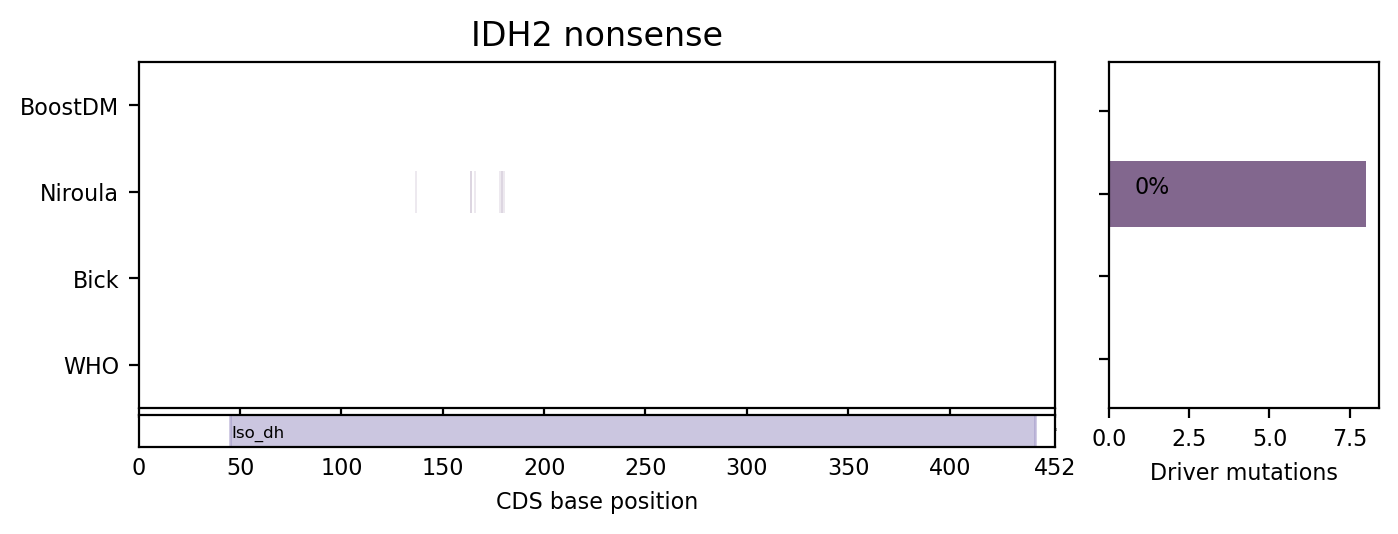

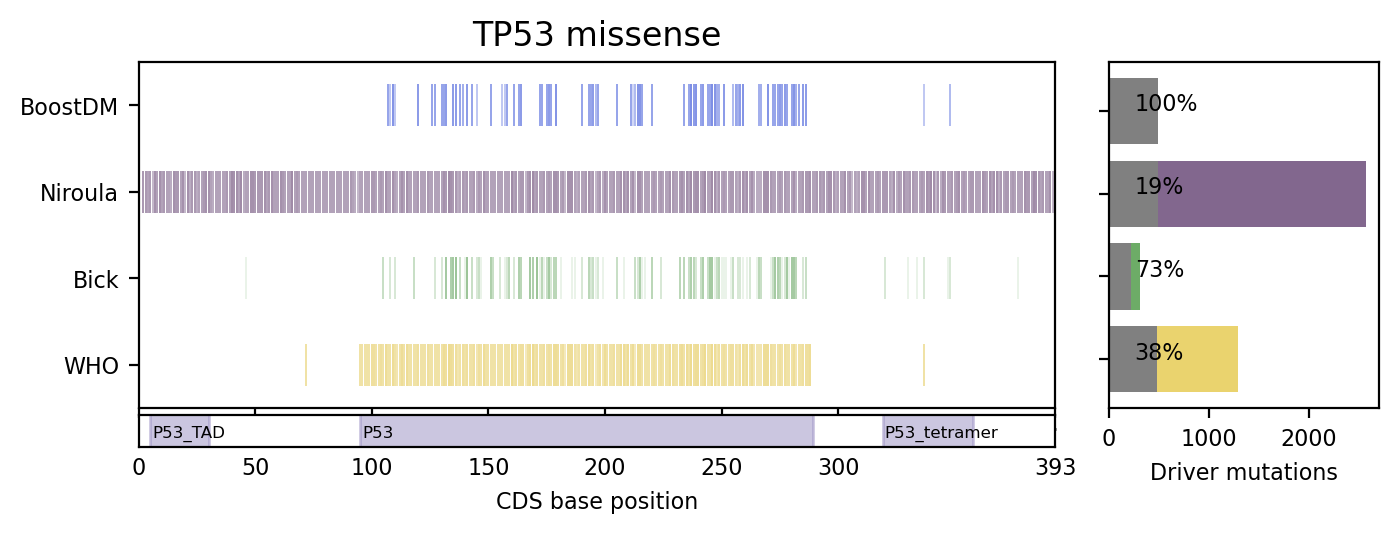

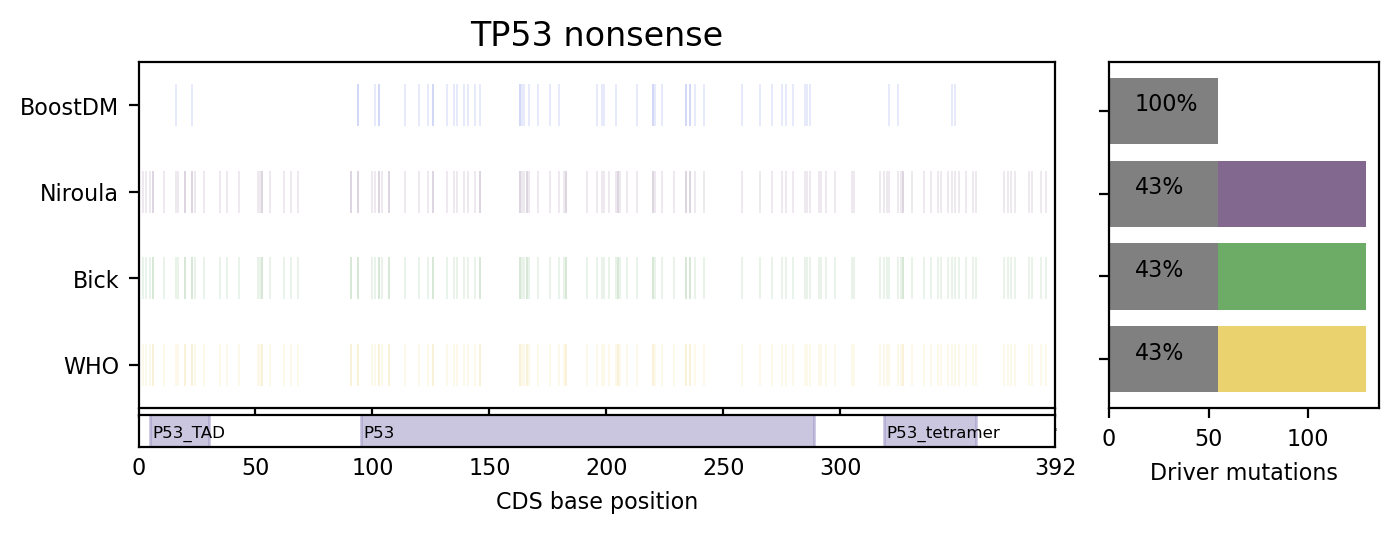

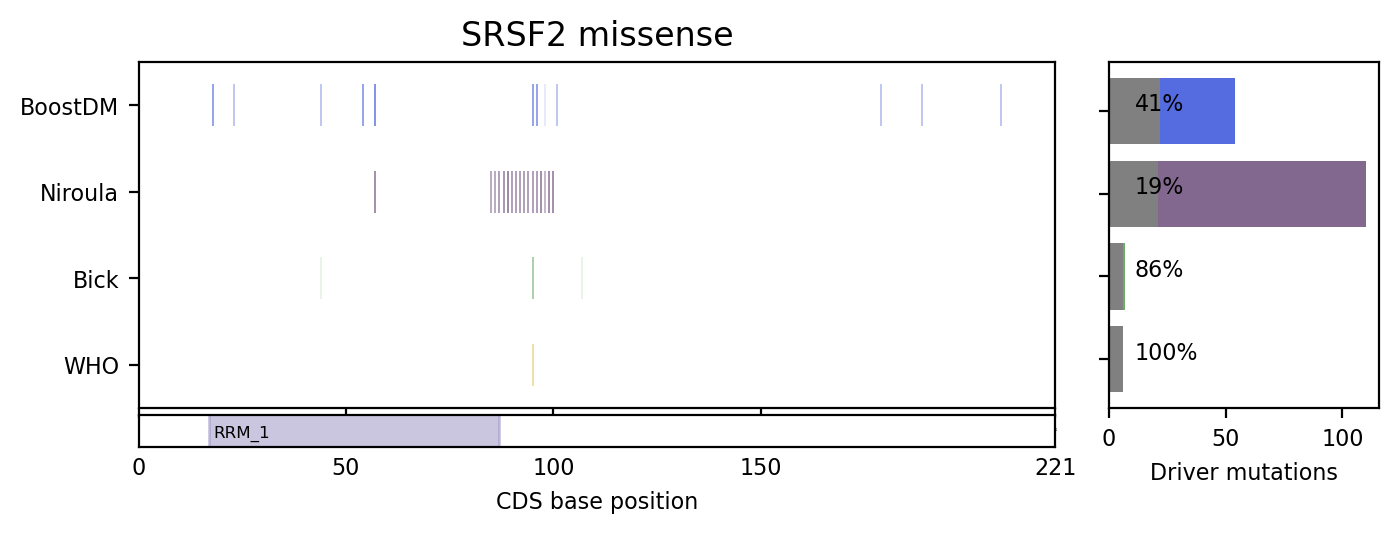

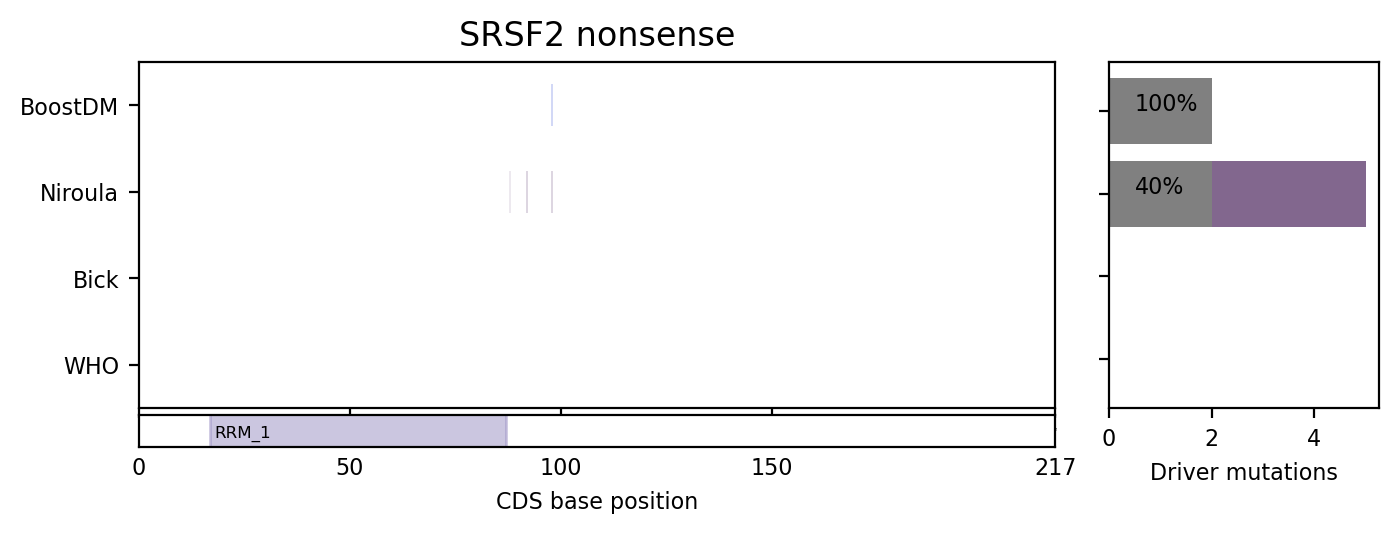

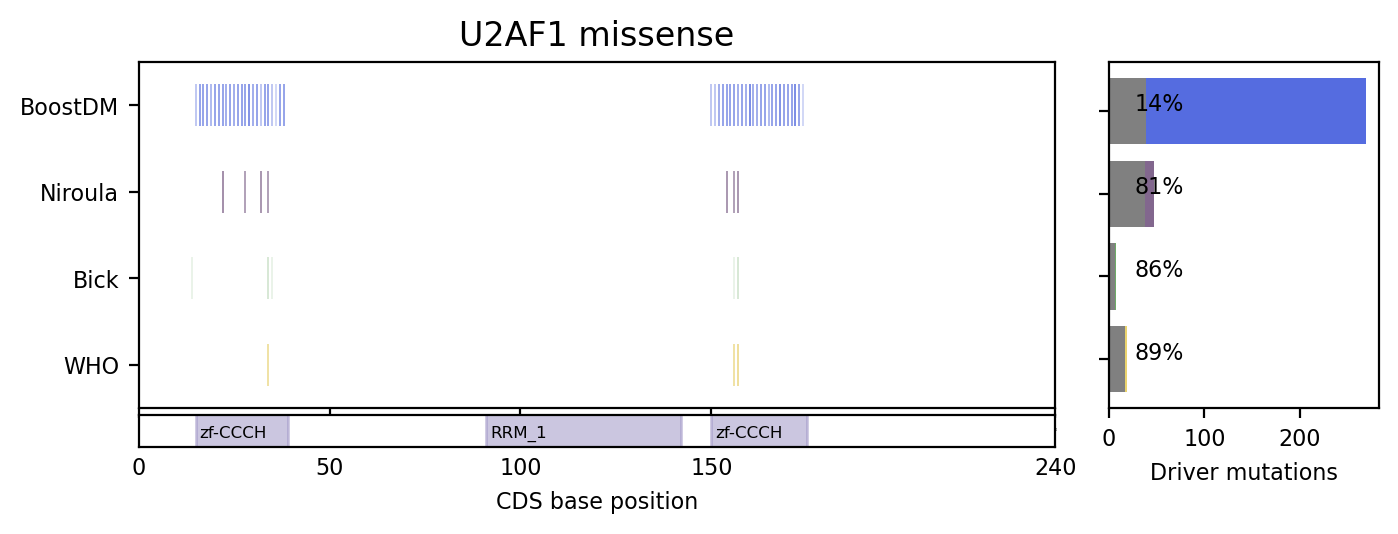

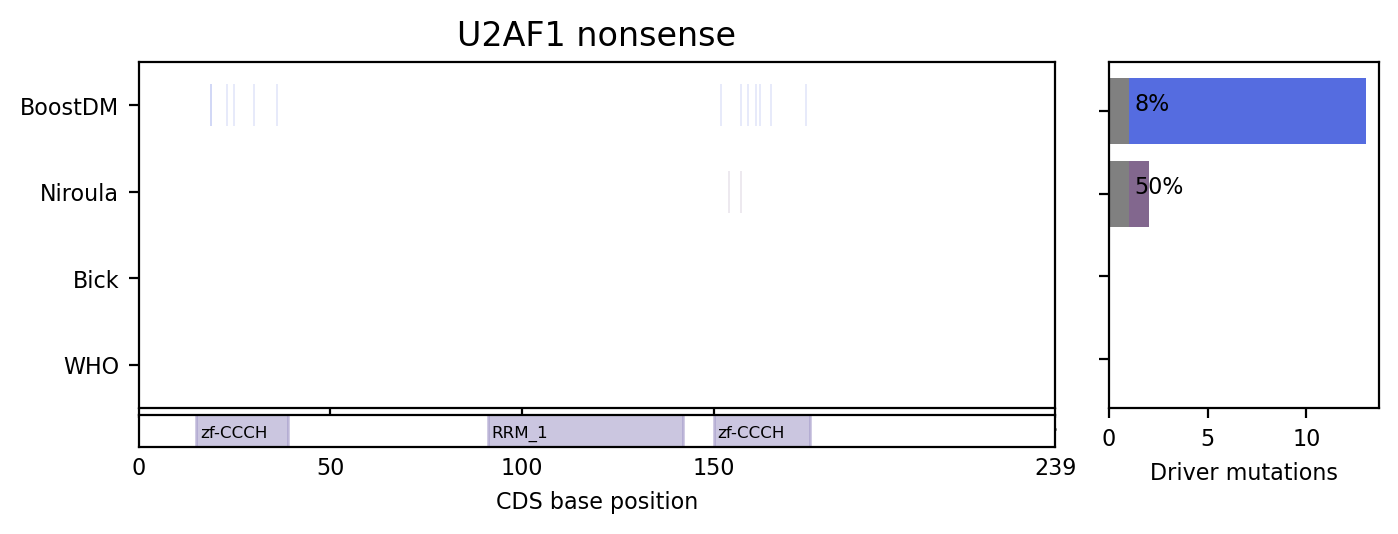

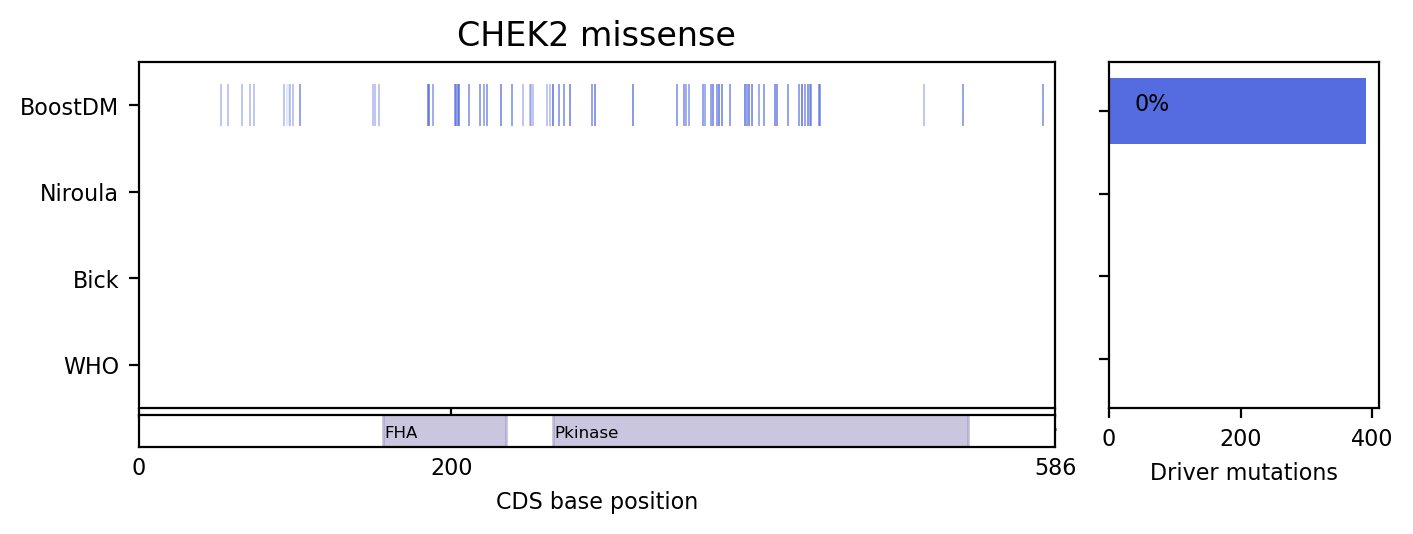

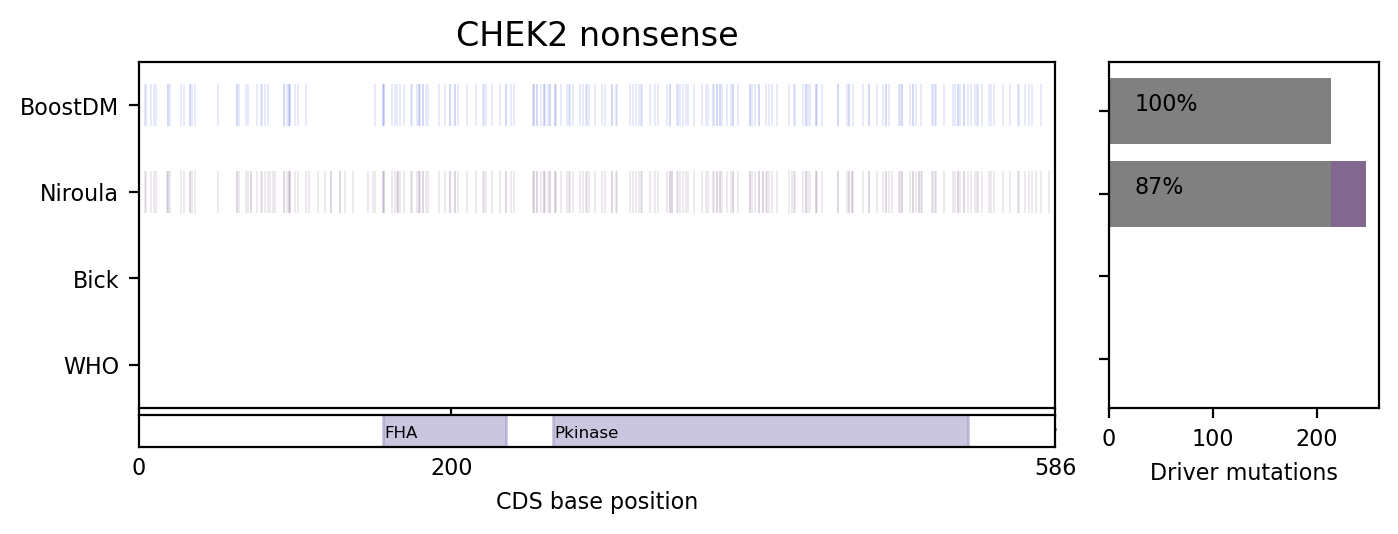

In [9]:
from matplotlib import gridspec
import matplotlib.patches as patches
import matplotlib
import matplotlib.pyplot as plt

for gene in ['SF3B1', 'DNMT3A', 'TET2', 'GNAS', 'ASXL1', 'PPM1D', 'IDH2', 'TP53', 'SRSF2', 'U2AF1', 'CHEK2']:
    
    for ttype in ['csqn_type_missense', 'csqn_type_nonsense']:
        

        fig = plt.figure(figsize=(8, 2.5), dpi=200)

        gs = gridspec.GridSpec(10, 4, figure=fig)
        # Method comparison
        ax0 = plt.subplot(gs[:-1, :3])
        #protein body
        ax1 = plt.subplot(gs[-1, :3], sharex=ax0)
        #Method overlapping
        ax2 = plt.subplot(gs[:-1, 3])

        GENE = Rules_matrix[(Rules_matrix['gene']==gene)&(Rules_matrix[ttype]==1)]

        # get PFAM domains and subset the mutation data
        PFAM_files = '../../Paper_data/pfam/pfam_biomart.tsv.gz'
        PFAM_info = '../../Paper_data/pfam/pfam_names.info.csv'
        subset_data_pfam = get_PFAMs_per_transcript(PFAM_files, PFAM_info, get_transctipt(gene))
        subset_data_pfam


        ######
        #BARPLOT
        ######
        BoostDM = len(GENE[(GENE['boostDM_class']==1)]['ID2'].to_list())
        Niroula = len(GENE[(GENE['Niroula']==1)]['ID2'].to_list())
        Overlapping_Niroula = len(GENE[(GENE['boostDM_class']==1) & (GENE['Niroula']==1)]['ID2'].to_list())
        Bick = len(GENE[(GENE['Bick']==1)]['ID2'].to_list())
        Overlapping_Bick = len(GENE[(GENE['boostDM_class']==1) & (GENE['Bick']==1)]['ID2'].to_list())
        WHO = len(GENE[(GENE['WHO']==1)]['ID2'].to_list())
        Overlapping_WHO = len(GENE[(GENE['boostDM_class']==1) & (GENE['WHO']==1)]['ID2'].to_list())
        allposition = set(GENE[(GENE['Niroula']==1)]['ID2'].to_list()+GENE[(GENE['Bick']==1)]['ID2'].to_list()+GENE[(GENE['WHO']==1)]['ID2'].to_list())
        Overlaping_all=len(GENE[(GENE['boostDM_class']==1) & (GENE['ID2'].isin(list(set(allposition))))])

        # create data
        x = ['WHO', 'Bick', 'Niroula', 'BoostDM']
        y1 = [Overlapping_WHO, Overlapping_Bick, Overlapping_Niroula, Overlaping_all]
        y2 = [0, 0, 0, BoostDM-Overlaping_all]
        y3 = [0, 0, Niroula-Overlapping_Niroula, 0]
        y4 = [0, Bick-Overlapping_Bick, 0, 0]
        y5 = [WHO-Overlapping_WHO, 0, 0, 0]
        h = 0.6
        size_param = 8

        # plot bars in stack manner
        max_len = max([BoostDM,Niroula,Bick,WHO])
        ax2.barh(x, y1, color='grey')
        ax2.barh(x, y2, left=y1, color='#556CE0')
        ax2.barh(x, y3, left=y1, color='#82678E')
        ax2.barh(x, y4, left=y1, color='#6DAC67')
        ax2.barh(x, y5, left=y1, color='#EAD36E')
        if WHO>0:
            ax2.text(0+(max_len/10), 0, str(round(Overlapping_WHO/WHO*100))+'%', size=size_param)
        if Bick>0:
            ax2.text(0+(max_len/10), 1, str(round(Overlapping_Bick/Bick*100))+'%', size=size_param)
        if Niroula>0:
            ax2.text(0+(max_len/10), 2, str(round(Overlapping_Niroula/Niroula*100))+'%', size=size_param)
        if BoostDM>0:
            ax2.text(0+(max_len/10), 3, str(round(Overlaping_all/BoostDM*100))+'%', size=size_param)
        ax2.set_yticklabels([])
        ax2.tick_params(axis='x', labelsize=8)
        ax2.set_xlabel('Driver mutations', fontsize = size_param)



        ######
        #Protein domains
        ######
        ax1.set_xlabel('CDS base position',fontsize = size_param)
        ax1.tick_params(axis='x', length=0)
        ax1.set_yticks([])

        ax1.set_ylim(0, 1)
        for i, r in subset_data_pfam.iterrows():
            start_base = r['START']
            size_base = r['SIZE']
            rect = patches.Rectangle(xy=(start_base, 0), width=size_base, height=5, color=r["Color"], alpha=0.5, zorder=2)
            ax1.annotate(text=r["DOMAIN_NAME"], xy=(start_base + 1, 0.3), fontsize=6)
            ax1.add_patch(rect)
        ax1.set_xlim(0, max(GENE['Prot_pos']))
        ax1.set_xticks(np.append(np.arange(0, max(GENE['Prot_pos']), 200)[:-1], max(GENE['Prot_pos'])))
        ax1.set_xticklabels(np.append(np.arange(0, max(GENE['Prot_pos']), 200)[:-1], max(GENE['Prot_pos'])), fontsize = 8)



        ######
        #Method comparison
        ######
        ax0.set_title(gene+' '+ttype.split('_')[-1])
        ax0.plot(GENE[GENE['boostDM_class']==1]['Prot_pos'], np.full_like(GENE[GENE['boostDM_class']==1]['Prot_pos'], 6), '|', markeredgewidth=0.1, markersize=15, color='#556CE0')
        ax0.plot(GENE[GENE['Niroula']==1]['Prot_pos'], np.full_like(GENE[GENE['Niroula']==1]['Prot_pos'], 4), '|k', markeredgewidth=0.1,  markersize=15, color='#82678E')
        ax0.plot(GENE[GENE['Bick']==1]['Prot_pos'], np.full_like(GENE[GENE['Bick']==1]['Prot_pos'], 2), '|k', markeredgewidth=0.1,  markersize=15, color='#6DAC67')
        ax0.plot(GENE[GENE['WHO']==1]['Prot_pos'], np.full_like(GENE[GENE['WHO']==1]['Prot_pos'], 0), '|k', markeredgewidth=0.1,  markersize=15, color='#EAD36E')
        ax0.set_ylim(-1, 7)
        if max(GENE['Prot_pos'])<500:
            ax0.set_xticks(np.append(np.arange(0, max(GENE['Prot_pos']), 50)[:-1], max(GENE['Prot_pos'])))
            ax0.set_xticklabels(np.append(np.arange(0, max(GENE['Prot_pos']), 50)[:-1], max(GENE['Prot_pos'])), fontsize = 0)
        elif max(GENE['Prot_pos'])<1400:
            ax0.set_xticks(np.append(np.arange(0, max(GENE['Prot_pos']), 200)[:-1], max(GENE['Prot_pos'])))
            ax0.set_xticklabels(np.append(np.arange(0, max(GENE['Prot_pos']), 200)[:-1], max(GENE['Prot_pos'])), fontsize = 0)
        elif max(GENE['Prot_pos'])>=1000:
            ax0.set_xticks(np.append(np.arange(0, max(GENE['Prot_pos']), 500)[:-1], max(GENE['Prot_pos'])))
            ax0.set_xticklabels(np.append(np.arange(0, max(GENE['Prot_pos']), 500)[:-1], max(GENE['Prot_pos'])), fontsize = 0)
        ax0.set_yticks([0,2,4,6])
        ax0.set_yticklabels(['WHO', 'Bick', 'Niroula', 'BoostDM'], fontsize = size_param)   
